### Policy Iteration for Stochastic Environments

#### Introduction to Stochastic MDPs

In **stochastic environments**, the outcome of taking an action is not deterministic. Unlike deterministic MDPs where $P(s'|s,a) \in \{0,1\}$, stochastic MDPs have probabilistic transitions where:

$$\sum_{s' \in S} P(s'|s,a) = 1 \quad \forall s \in S, a \in A$$

This introduces **uncertainty** into the decision-making process, making optimal policy computation more challenging but also more realistic for many real-world scenarios.

#### Stochastic FrozenLake Environment

In the stochastic FrozenLake environment (`is_slippery=True`):
- The agent **intends** to move in a chosen direction
- Due to the slippery ice, the agent may **slip** and move in unintended directions
- Each action can result in **multiple possible outcomes** with different probabilities

#### Mathematical Challenges

Stochastic environments require us to:
1. **Account for uncertainty** in transition probabilities during policy evaluation
2. **Compute expected values** over all possible next states  
3. **Handle multiple possible outcomes** for each action during policy improvement

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [2]:
action_dict = {0: "Left", 1: "Down", 2: "Right", 3: "Up"}

In [3]:
def print_policy(policy, grid=(4, 4)):
    
    policy_map = np.empty(grid).astype(str)

    for r in range(grid[0]):
        for c in range(grid[1]):
            index =  r * grid[0] +  c
                
            selected_action = action_dict[policy[index]]
            selected_action = selected_action[0]

            policy_map[r, c] = selected_action


    print("Policy")
    print(policy_map)

#### Stochastic Policy Evaluation

In stochastic environments, **policy evaluation** must account for the probabilistic nature of state transitions. Unlike deterministic environments where each action leads to exactly one next state, here we must compute **expected values** over all possible outcomes.

##### Mathematical Formulation

For a deterministic policy $\pi(s)$ in a stochastic environment, the Bellman equation becomes:

$$V^\pi(s) = \sum_{s'} P(s'|s,\pi(s))[R(s,\pi(s),s') + \gamma V^\pi(s')]$$

Since multiple next states $s'$ are possible with different probabilities, we must:

1. **Identify all possible transitions**: For action $a = \pi(s)$, find all $(s', p, r)$ tuples
2. **Compute weighted sum**: Sum over all possible outcomes weighted by their probabilities
3. **Apply Bellman operator**: $V_{k+1}^\pi(s) = \sum_{s'} P(s'|s,\pi(s))[R + \gamma V_k^\pi(s')]$

##### Key Differences from Deterministic Case

- **Multiple outcomes per action**: Each action can lead to several possible next states
- **Probability weighting**: Must multiply each outcome by its transition probability
- **Expected value computation**: The value function represents expected cumulative reward

The implementation iterates over all possible transitions for the policy-selected action and computes the expected value.

In [4]:
def policy_evaluation(policy, gamma=0.99, iterations=1000, epsilon=1e-10):

    V = np.zeros(shape=env.observation_space.n)


    for _ in range(iterations):
        V_k = np.copy(V)

        for s in range(env.observation_space.n):

            # Action given by policy, But can't take directly as of stochastic env
            wanted_action = policy[s]
            possible_actions = env.unwrapped.P[s][wanted_action]

            V_s = 0

            for prob, s_next, reward, terminal in possible_actions:
                
                V_s += prob * (reward + gamma * V_k[s_next])

            V[s] = V_s

        if np.max(np.abs(V - V_k)) < epsilon:
            break

    return V

#### Stochastic Policy Improvement

**Policy improvement** in stochastic environments requires computing **action-value functions** (Q-values) for all possible actions, accounting for the probabilistic transitions.

##### Mathematical Foundation

Given the value function $V^\pi(s)$ from policy evaluation, we compute Q-values for each action:

$$Q^\pi(s,a) = \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^\pi(s')]$$

The **improved policy** is then:
$$\pi'(s) = \arg\max_{a \in A} Q^\pi(s,a)$$

##### Stochastic Q-Value Computation

For each state $s$ and action $a$:

1. **Enumerate all possible transitions**: Find all $(prob, s', reward, done)$ tuples for $(s,a)$
2. **Compute expected Q-value**: $Q(s,a) = \sum_{i} prob_i \cdot (reward_i + \gamma \cdot V(s'_i))$
3. **Select greedy action**: Choose action with maximum Q-value

##### Handling Uncertainty

Unlike deterministic environments, each action's value depends on:
- **All possible next states** it can lead to
- **Transition probabilities** to each next state  
- **Rewards** associated with each transition

The algorithm must evaluate the **expected utility** of each action considering all possible outcomes, making the policy robust to environmental uncertainty.

In [5]:
def policy_improvement(values, gamma=0.99):
    new_policy = np.zeros(env.observation_space.n)


    for s in range(env.observation_space.n):

        Q_s = []

        for wanted_action in range(env.action_space.n):
            possible_actions = env.unwrapped.P[s][wanted_action]

            Q_sa = 0

            for prob, s_next, reward, terminal in possible_actions:
                Q_sa += prob * (reward + gamma * values[s_next])

            Q_s.append(Q_sa)

        best_action = np.argmax(Q_s)


        new_policy[s] = best_action


    return new_policy

#### Complete Stochastic Policy Iteration

The **complete policy iteration algorithm** for stochastic environments follows the same two-step process as deterministic environments, but with modified computations to handle probabilistic transitions.

##### Algorithm Steps

1. **Initialize**: Start with arbitrary policy $\pi_0$
2. **Repeat until convergence**:
   - **Stochastic Policy Evaluation**: Compute $V^{\pi_k}$ using expected values over all possible transitions
   - **Stochastic Policy Improvement**: Update $\pi_{k+1}$ by maximizing expected Q-values
3. **Convergence**: Stop when $\pi_{k+1} = \pi_k$

##### Key Adaptations for Stochastic Environments

**Policy Evaluation Adaptation**:
- Must iterate over **all possible outcomes** for each policy action
- Compute **probability-weighted** value updates
- Handle **multiple transition probabilities** per action

**Policy Improvement Adaptation**:
- Calculate **expected Q-values** for all actions considering uncertainty
- Select action that maximizes **expected utility**
- Account for **risk** inherent in stochastic transitions

##### Convergence Properties

- **Guaranteed convergence** to optimal policy $\pi^*$ (same as deterministic case)
- **Finite convergence** in finite state and action spaces
- **Robustness** to environmental uncertainty through expected value computations

The algorithm produces policies that are **optimal under uncertainty**, maximizing expected cumulative reward despite stochastic transitions.

In [6]:
def policy_iteration(env, num_iterations=1000, gamma=0.99):

    policy = np.random.randint(low=0, high=env.action_space.n, size=(env.observation_space.n))

    for _ in range(num_iterations):

        values = policy_evaluation(policy, gamma=gamma, iterations=num_iterations)
        update_policy = policy_improvement(values, gamma=gamma)

        # Convergence
        if np.all(policy == update_policy):
            break

        policy = update_policy

    return policy

#### Testing the Optimal Policy in Stochastic Environment

Now we apply our policy iteration algorithm to the **stochastic FrozenLake** environment and evaluate its performance.

##### Environment Setup
- **Stochastic transitions**: `is_slippery=True` introduces randomness
- **Uncertainty**: Agent may slip and move in unintended directions
- **Challenge**: Policy must be robust to unpredictable outcomes

##### Performance Evaluation
Since the environment is stochastic, we cannot expect 100% success rate even with the optimal policy. Instead, we:

1. **Run multiple episodes** to estimate average performance
2. **Measure success rate** over many trials
3. **Account for inherent randomness** in environment dynamics

##### Expected Results
The optimal policy should:
- **Maximize expected reward** despite uncertainty
- **Achieve reasonable success rate** given environmental constraints
- **Balance risk and reward** in action selection

Let's compute the optimal policy and evaluate its performance:

In [7]:
env = gym.make('FrozenLake-v1', map_name='4x4', render_mode='rgb_array', is_slippery=True)

learned_policy = policy_iteration(env, gamma=0.99)

##### Performance Analysis

Due to the stochastic nature of the environment, we need to evaluate policy performance through **statistical analysis** rather than single-episode success. The optimal policy maximizes **expected** success rate, not guaranteed success.

In [8]:
num_games=1000
max_steps=500

game_success=0

for _ in range(num_games):
    observation, _ = env.reset()

    for _ in range(max_steps):

        action = int(learned_policy[observation])

        observation, reward, done, _, _ = env.step(action)

        if done:
            if reward > 0:
                game_success += 1
            break

successful_game_ratio = game_success / num_games
print(f"Successful game ratio: {successful_game_ratio}")

Successful game ratio: 0.827


#### Discount Factor ($\gamma$) Analysis

The **discount factor** $\gamma$ plays a crucial role in reinforcement learning by determining how much the agent values **future rewards** relative to **immediate rewards**.

##### Mathematical Impact of $\gamma$

$$V^\pi(s) = \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t R_{t+1} | S_0 = s\right]$$

- **$\gamma = 0$**: Agent only cares about immediate rewards (myopic behavior)
- **$\gamma = 1$**: All future rewards are equally important (far-sighted behavior)  
- **$0 < \gamma < 1$**: Exponential decay of future reward importance

##### Expected Effects in Stochastic FrozenLake

- **Low $\gamma$**: May lead to risky strategies since future consequences are discounted
- **High $\gamma$**: More conservative policies that consider long-term outcomes
- **Optimal $\gamma$**: Balances immediate and future rewards for best performance

Let's analyze how different discount factors affect policy performance in our stochastic environment:

In [9]:
gamma_values = [0.1, 0.5, 0.9, 0.99]
gamma_names = ["γ=0.1 (Short-term)", "γ=0.5 (Balanced)", "γ=0.9 (Long-term)", "γ=0.99 (Far-sighted)"]

print("Training policies for different discount factors...")
print("=" * 50)

Training policies for different discount factors...


In [10]:
gamma_success_rates = []
gamma_policies = []

for i, gamma in enumerate(gamma_values):
    print(f"Training policy for {gamma_names[i]}...")
    
    # Train policy with current gamma
    learned_policy_for_gamma = policy_iteration(env, gamma=gamma)
    gamma_policies.append(learned_policy_for_gamma)
    
    # Test policy performance
    num_games = 1000
    max_steps = 500
    game_success = 0
    
    for _ in range(num_games):
        observation, _ = env.reset()
    
        for _ in range(max_steps):
            action = int(learned_policy_for_gamma[observation])
            observation, reward, done, _, _ = env.step(action)
    
            if done:
                if reward > 0:
                    game_success += 1
                break
                
    success_rate = game_success / num_games
    gamma_success_rates.append(success_rate)
    print(f"Success rate: {success_rate:.3f}")

Training policy for γ=0.1 (Short-term)...
Success rate: 0.441
Training policy for γ=0.5 (Balanced)...
Success rate: 0.457
Training policy for γ=0.9 (Long-term)...
Success rate: 0.766
Training policy for γ=0.99 (Far-sighted)...
Success rate: 0.815


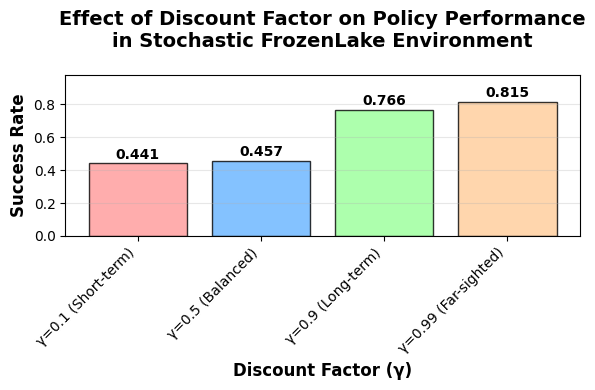

In [12]:
plt.figure(figsize=(6, 4))

bars = plt.bar(gamma_names, gamma_success_rates, 
               color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'],
               alpha=0.8, edgecolor='black', linewidth=1)

for i, (bar, rate) in enumerate(zip(bars, gamma_success_rates)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel("Discount Factor (γ)", fontsize=12, fontweight='bold')
plt.ylabel("Success Rate", fontsize=12, fontweight='bold')
plt.title("Effect of Discount Factor on Policy Performance\nin Stochastic FrozenLake Environment", 
          fontsize=14, fontweight='bold', pad=20)
plt.ylim(0, max(gamma_success_rates) * 1.2)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

##### Interpretation of Results

The discount factor analysis reveals important insights about temporal decision-making in stochastic environments:

**Expected Patterns**:
- **Low γ (0.1)**: Short-sighted policies may perform poorly due to inadequate planning
- **Medium γ (0.5-0.9)**: Balanced approach often yields good performance
- **High γ (0.99)**: Far-sighted policies maximize long-term expected reward

**Key Insights**:
1. **Optimal γ balances** immediate and future rewards for the specific environment
2. **Too low γ** leads to myopic behavior that ignores important future consequences  
3. **Too high γ** may overemphasize distant rewards in finite-horizon problems
4. **Environment-specific tuning** is crucial for optimal performance
